### Find efficient frontier 

In [11]:
# import necessary packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [12]:
# define style of graphic
sns.set_style('darkgrid')

In [13]:
# function to calculate portfolio return given a vector of weights
def portfolio_return_mu(weights, mu):
    return weights.T @ mu

# function to calculate portfolio risk (std) given a vector of weights
def portfolio_sigma(weights, sigma):
    return np.sqrt(weights.T @ sigma @ weights)

# Return an array of equal weights that sum to one of dimension length
def get_equal_weights(length):
    return np.array([1 / length] * length)

In [14]:
# get data
df = pd.read_csv('../Data/20241010_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)

# drop consumer confidence as not enought data
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now

# drop 10y treasury index and calculate new
df.drop('10y treasury Index', axis=1, inplace=True) 
ten_y_index = [100]
delta = -9.0/100.0
for i in range(len(df['10y'])-1):
    change_in_bp = (df['10y'][i+1] - df['10y'][i])/ df['10y'][i]
    ten_y_index.append(ten_y_index[i] + df['10y'][i]/(12) + change_in_bp * delta)
df['10y treasury Index'] = np.array(ten_y_index)

# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]


# select data of all assets
data_all_assets_training = df_training[['SP500','Gold','3M-Index','10y treasury Index']].pct_change()
data_all_assets_test = df_test[['SP500','Gold','3M-Index','10y treasury Index']].pct_change()

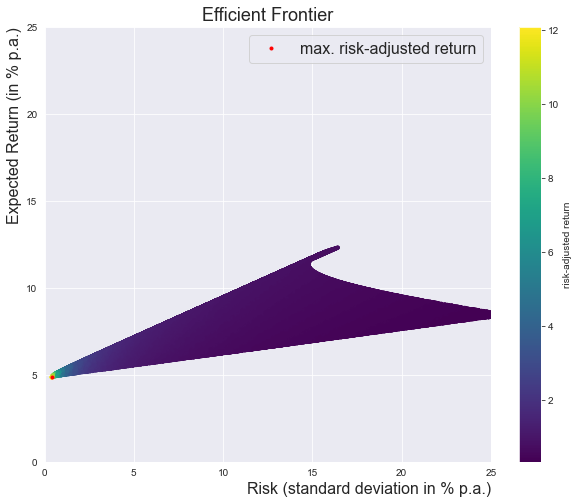

In [15]:
# using colorbar causes a warning
# switch warnings off
import warnings
warnings.filterwarnings("ignore")

# select data of all assets
data_risky_assets_training = df_training[['SP500','Gold','10y treasury Index']].pct_change().dropna()
data_risky_assets_test = df_test[['SP500','Gold','10y treasury Index']].pct_change().dropna()


# first 10y of data used to as history for learning and first distribution of prices
start = 240 # in months

# calculate the mean and the standard deviation of the trainings data
mu = data_risky_assets_training.iloc[120:start,:].mean(axis=0).to_numpy()
sigma = data_risky_assets_training.iloc[120:start,:].cov().to_numpy() 

# number of assets
n_assets = len(data_risky_assets_training.columns)

# number of simulated portfolios
n_portfolios = 500000

# container to store results
portfolio_returns = []
portfolio_risks = []
portfolio_weights = []

# initialize max_sharpe-ratio with minus infinity
max_sharpe_ratio = -np.inf

# simulate random portfolios
for _ in range(n_portfolios):
    # random weights
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)  # normalize to sum to one
    
    # calc expected return of portfolio
    portfolio_return =  portfolio_return_mu(mu = mu, weights = weights) *12 # to get p.a. values
    
    # calc portfolio risk (std)
    portfolio_std_dev =  portfolio_sigma(weights=weights, sigma=sigma) * np.sqrt(12)
    
    # store results
    portfolio_returns.append(portfolio_return)
    portfolio_risks.append(portfolio_std_dev)
    portfolio_weights.append(weights)

    if portfolio_return / portfolio_std_dev > max_sharpe_ratio:
        sharpe_return = portfolio_return
        sharpe_std = portfolio_std_dev
        max_sharpe_ratio = portfolio_return / portfolio_std_dev 
        max_sharpe_ratio_weights = weights

# approximate efficient frontier
portfolio_returns = np.array(portfolio_returns)
portfolio_risks = np.array(portfolio_risks)

plt.figure(figsize=(10, 8))
plt.scatter(portfolio_risks * 100, portfolio_returns *100, c=portfolio_returns/portfolio_risks, cmap='viridis', marker='.')
plt.colorbar(label='risk-adjusted return')
plt.plot(sharpe_std *100, sharpe_return *100, '.', color='red', label='max. risk-adjusted return')
plt.xlim(0,25)
plt.ylim(0, 25)
plt.xlabel('Risk (standard deviation in % p.a.)', loc='right',fontsize=16)
plt.ylabel('Expected Return (in % p.a.)', loc='top', fontsize=16)
plt.title('Efficient Frontier', fontsize=18)
plt.legend(fontsize=16)

plt.show()

#### Simulte efficient frontier without 10y-treasury-index

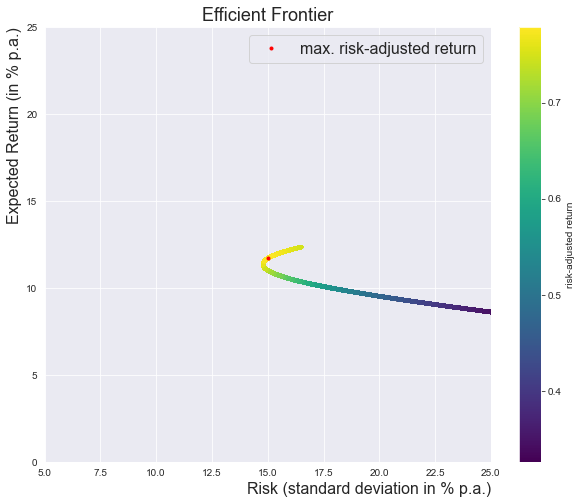

In [16]:
# select data of all assets
data_risky_assets_training = df_training[['SP500','Gold']].pct_change().dropna()
data_risky_assets_test = df_test[['SP500','Gold']].pct_change().dropna()


# first 10y of data used to as history for learning and first distribution of prices
start = 240 # in months


# calculate the mean and the standard deviation of the trainings data
mu = data_risky_assets_training.iloc[120:start,:].mean(axis=0).to_numpy()
sigma = data_risky_assets_training.iloc[120:start,:].cov().to_numpy() 

# number of assets
n_assets = len(data_risky_assets_training.columns)

# number of simulated portfolios
n_portfolios = 500000

# container to store results
portfolio_returns = []
portfolio_risks = []
portfolio_weights = []

max_sharpe_ratio = -np.inf

# simulate random portfolios
for _ in range(n_portfolios):
    # random weights
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)  # normalize to sume to one
    
    # calc expected return of portfolio
    portfolio_return =  portfolio_return_mu(mu = mu, weights = weights) *12 # to get p.a. values
    
    # calc portfolio risk (std)
    portfolio_std_dev =  portfolio_sigma(weights=weights, sigma=sigma) * np.sqrt(12)
    
    # store results
    portfolio_returns.append(portfolio_return)
    portfolio_risks.append(portfolio_std_dev)
    portfolio_weights.append(weights)

    if portfolio_return / portfolio_std_dev > max_sharpe_ratio:
        sharpe_return = portfolio_return
        sharpe_std = portfolio_std_dev
        max_sharpe_ratio = portfolio_return / portfolio_std_dev 
        max_sharpe_ratio_weights = weights

# approximate efficient frontier
portfolio_returns = np.array(portfolio_returns)
portfolio_risks = np.array(portfolio_risks)

plt.figure(figsize=(10, 8))
plt.scatter(portfolio_risks * 100, portfolio_returns *100, c=portfolio_returns/portfolio_risks, cmap='viridis', marker='.')
plt.colorbar(label='risk-adjusted return')
plt.plot(sharpe_std *100, sharpe_return *100, '.', color='red', label='max. risk-adjusted return')
plt.xlim(5,25)
plt.ylim(0, 25)
plt.xlabel('Risk (standard deviation in % p.a.)', loc='right',fontsize=16)
plt.ylabel('Expected Return (in % p.a.)', loc='top', fontsize=16)
plt.title('Efficient Frontier', fontsize=18)
plt.legend(fontsize=16)
plt.show()

#### weights of the portfolio with the highest Sharpe ratio

In [17]:
max_sharpe_ratio_weights

array([0.8359148, 0.1640852])

#### draw CAPM-line and find tangency portfolio

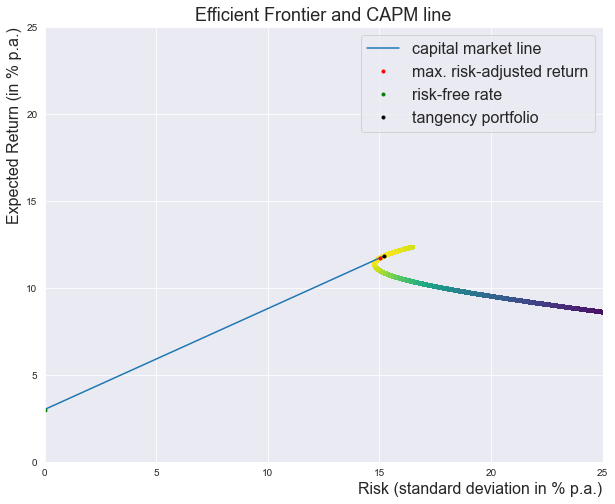

In [18]:
list_of_points = list(zip(portfolio_risks, portfolio_returns, portfolio_weights))
# set risk-free to 3%
r_f = 0.03
max_sharpe_return = -np.inf
max_sharpe_risk = -np.inf
sharpe = -np. inf
for tupel in list_of_points:
    if (tupel[1] - r_f) / tupel[0] > sharpe:
        max_sharpe_return = tupel[1]
        max_sharpe_risk = tupel[0]
        sharpe = (tupel[1] - r_f) / tupel[0]
        sharpe_weights = tupel[2]

plt.figure(figsize=(10, 8))
x_2 = np.linspace(0,max_sharpe_risk * 100,100)
y_2 = x_2 * sharpe + r_f*100
plt.plot(x_2, y_2, label = 'capital market line' )
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.scatter(portfolio_risks * 100, portfolio_returns *100, c=portfolio_returns/portfolio_risks, cmap='viridis', marker='.')
plt.plot(sharpe_std *100, sharpe_return *100, '.', color='red', label='max. risk-adjusted return')

plt.plot(0, r_f *100, '.', color='green', label='risk-free rate')
plt.plot(max_sharpe_risk *100, max_sharpe_return *100, '.', color='black', label='tangency portfolio')
plt.xlabel('Risk (standard deviation in % p.a.)', loc='right',fontsize=16)
plt.ylabel('Expected Return (in % p.a.)', loc='top', fontsize=16)
plt.title('Efficient Frontier and CAPM line', fontsize=18)
plt.legend(fontsize=16)

plt.show()

### Tangency Point with  a risk-free rate of 3%

In [19]:
sharpe_weights

array([0.86890694, 0.13109306])